In [122]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### We're importing the following libraries for this project:
1. `requests`, to pull down the full 2019 air yards data from airyards.com   
2. `pandas` & `numpy` to create DataFrames for air yards stats & defensive DVOA stats
3. `seaborn` & `matplotlib` for graphing & visualization functionality

In [123]:
air_yards = requests.get("http://api.airyards.com/2019/weeks")
air_yards = air_yards.json()



Then, we'll use `requests.get()` to pull data from airyards.com's API for all players' 2019 data. From there, requests' `.json()` function can convert the raw JSON data from the website into an easy-to-use dictionary (**Note**: the panda's function `.read_json()` could also be used to convert the JSON directly to a DataFrame).

In [124]:
ay_df = pd.DataFrame.from_dict(air_yards)
ay_df = ay_df[ay_df['position'].isin(['WR', 'RB', 'TE'])]
ay_df['Fantasy Points'] = (ay_df.td * 6) + (ay_df.rush_td * 6) + (ay_df.rec_yards * 0.1) + \
                          (ay_df.rush_yards * 0.1) +  (ay_df.rec * 0.5)
ay_df.set_index('index', inplace=True)

Once the dictionary **air_yards** is created from airyards.com's JSON data, pandas' `from_dict()` function is used to convert the dictionary to a pandas DataFrame.  Then, `ay_df = ay_df[ay_df['position'].isin(['WR', 'RB', 'TE'])]` is used to remove any players whose position is not either a Wide Receiver (WR), Running Back (RB), or Tight End (TE). (`ay_df['position']` is used to filter down to the position column in the DataFrame, and the `.isin` function is used to produce a `True` value for any player that is a WR, RB, or TE.  From there, the entire `ay_df` DataFrame is filtered to just the `True` values, leaving us with a DataFrame of just position players whose data we need to analyze.)

Finally, a new *Fantasy Points* column is created, which produces a point total based on standard fantasy scoring (i.e. one receiving or rushing yard is worth 1/10 of a point, etc.).  Later, when using machine learning to see if there is any correlation between a player's prior week stats, an opponents DVOA, and the player's current week's fantasy output, this column will be used.

In [125]:
ay_df.sort_values(['player_id', 'week'], inplace=True)
for stat in ['tar', 'td', 'rush_td', 'rec', 'rec_yards', 'rush_yards', 'yac', 'air_yards', \
             'tm_att', 'team_air', 'aypt', 'racr', 'ms_air_yards', 'target_share', \
             'wopr']:
    for prior_week in range(1, 5):
        ay_df['{}wk_prior_{}'.format(prior_week, stat)] = ay_df.groupby(['player_id'])[stat].shift(prior_week)

A key part of this analysis will be to look at how histroical / trailing statistics can be used to predict future daily fantasy output (e.g. does the player's output 1, 2, 3, and/or 4 weeks ago correlate to future performance?).

To get this data folded into our *ay_df* DataFrame, we'll take all of the columns with statistics, and loop through them.  We can do this by looping through each stat we want to roll forward (e.g. targets, rushing touchdowns, etc.), and then within each statistics nest a second loop that iterates through the numbers 1-4.

Ultimately, `ay_df['{}wk_prior_{}'.format(prior_week, stat)] = ay_df.groupby(['player_id'])[stat].shift(prior_week)` will equate to the following (let's use the stat 'td' and the week number 3 as an example):
    1. Create a column called *3wk_prior_td* within the ay_df
    2. Column *3wk_prior_td* will be the column *td*, shifted forward 3 weeks.  So, if Player A had 2 touchdowns in week 6, then Player A's row for week 9 would now how a value of 2 in the *3wk_prior_td* (showing that 3 weeks ago -- as of week 9 -- he had 2 touchdowns in his game).
   

To see if this worked, we can look at a single player's statistics over the 2019 season, and see if the stats shifted forward correctly (example below uses *air yards*).

In [126]:
ay_df[ay_df['full_name'] == 'Julio Jones'][['full_name', 'week', 'air_yards', '1wk_prior_air_yards', '2wk_prior_air_yards', \
                                           '3wk_prior_air_yards', '4wk_prior_air_yards', ]].reset_index(drop=True)

,full_name,week,air_yards,1wk_prior_air_yards,2wk_prior_air_yards,3wk_prior_air_yards,4wk_prior_air_yards
0,Julio Jones,1,107,NaN,NaN,NaN,NaN
1,Julio Jones,2,131,107.0,NaN,NaN,NaN
2,Julio Jones,3,135,131.0,107.0,NaN,NaN
3,Julio Jones,4,101,135.0,131.0,107.0,NaN
4,Julio Jones,5,99,101.0,135.0,131.0,107.0
5,Julio Jones,6,98,99.0,101.0,135.0,131.0
6,Julio Jones,7,139,98.0,99.0,101.0,135.0
7,Julio Jones,8,145,139.0,98.0,99.0,101.0
8,Julio Jones,10,118,145.0,139.0,98.0,99.0
9,Julio Jones,11,121,118.0,145.0,139.0,98.0


We can see in the above example, Julio Jones stats have shifted forward correclty.  For example, we can look at week 6's value in *4wk_prior_air_yards* and see that week 2's air yards are now there (135 yards).

Next, we'll want to create a column that shows the delta between a players statistics week over week (e.g., what was the growth / decline in targets or receiving touchdowns from 3 weeks ago to 2 weeks ago?).  The theory here is that it will be a useful gauge to catch players that are seeing an increase/decrease in usage as a result of above-, or below-, average play.

In [135]:
for stat in ['tar', 'td', 'rush_td', 'rec', 'rec_yards', 'rush_yards', 'yac', 'air_yards', \
            'tm_att', 'team_air', 'aypt', 'racr', 'ms_air_yards', 'target_share', \
             'wopr']:
    for prior_week in range(1, 5):
        ay_df['{}wk_prior_{}_delta'.format(prior_week, stat)] = ay_df['{}wk_prior_{}'.format(prior_week, stat)].diff()

Now, we have both the raw quantitative data for each player's week, as well as the week over week change for each stat.  In the example above, for week 8, we now have a data point showing that Julio Jones had 118 air yards that week, as well as 145 last week, *and* that last week's total was 6 yards higher than the prior weeks total (139 yards 2 weeks ago).

In [136]:
ay_df[ay_df['full_name'] == 'Julio Jones'][['full_name', 'week', 'air_yards', '1wk_prior_air_yards', '2wk_prior_air_yards', \
                                           '1wk_prior_air_yards_delta', '2wk_prior_air_yards_delta']].reset_index(drop=True)



,full_name,week,air_yards,1wk_prior_air_yards,2wk_prior_air_yards,1wk_prior_air_yards_delta,2wk_prior_air_yards_delta
0,Julio Jones,1,107,NaN,NaN,NaN,NaN
1,Julio Jones,2,131,107.0,NaN,NaN,NaN
2,Julio Jones,3,135,131.0,107.0,24.0,NaN
3,Julio Jones,4,101,135.0,131.0,4.0,24.0
4,Julio Jones,5,99,101.0,135.0,-34.0,4.0
5,Julio Jones,6,98,99.0,101.0,-2.0,-34.0
6,Julio Jones,7,139,98.0,99.0,-1.0,-2.0
7,Julio Jones,8,145,139.0,98.0,41.0,-1.0
8,Julio Jones,10,118,145.0,139.0,6.0,41.0
9,Julio Jones,11,121,118.0,145.0,-27.0,6.0


In [142]:
cum_targs = ay_df.groupby('player_id')['tar'].rolling(window = 3, min_periods=1).sum()
ay_df['cum_targs'] = cum_targs.reset_index(level=0, drop=True)
ay_df.groupby('player_id')['cum_targs'].shift(1)
ay_df['depth_chart'] = ay_df.groupby(['team', 'week', 'position'])['cum_targs'].rank(ascending = False, method = 'min')

The next column we'll want to add is a depth chart column - this will let us eventually line up defensive DVOA by WR against each player's depth chart rating.

Let's first create a column with a rolling counter of targets for each reciever over the previous three weeks.  This will give us a good balance between historic data & recent trends, where we can see if there are certain players that have an increase in tragets (i.e. improving health, increased target share after a teammate's injury, improved performance, etc.).

The first thing we'll do is create a Series **cum_targs** for our cumulative targets. `cum_targs = ay_df.groupby('player_id')['tar'].rolling(window = 3, min_periods=1).sum()` will use pandas' `.rolling()` function to help us generate a column with a cumulative sum.

We'll use `ay_df.groupby('player_id')` to group our players by their unique ID - this will help us avoid the issue of our data "leaking over" from one player's week 17 total into the next player's week 1 total within the larger **ay_df** DataFrame.  Then, we'll use `[tar]` to pull each player's weekly target total.  Finally, `.rolling(window = 3, min_periods=1).sum()` will use the `.rolling()` function to create a colum with the sum of 3 weeks worth of data.  

However, we'll want to then shift the column forward once in order to make each week's **cum_targs** column the total of the *prior* 3 weeks before the current week, rather than the column after `ay_df.groupby('player_id')['tar'].rolling(window = 3, min_periods=1).sum()`, which is a cumulative sum *including* the current week.  To do this, we can use `ay_df.groupby('player_id')['cum_targs'].shift(1)` to push our cumulative target values down one row.

The last thing we'll have to do is use this cumulative target count to determine where on the depth chart each player sits (e.g. who is the WR1, WR2, and WR3).  The code `ay_df['depth_chart'] = ay_df.groupby(['team', 'week', 'position'])['cum_targs'].rank(ascending = False, method = 'min')` will do this for our DataFrame.  

Specifically, it will create a **depth_chart** column, and then use pandas' `.rank()` function to iterate through each team's wide receivers, tight ends, and running backs (because we are using `.groupby()` on the **position** column) to assign them a rank that updates each week as players receive (pun intended) more or fewer targets than their teammates.

In [143]:
ay_df[(ay_df['team'] == 'GB')].sort_values(['week', 'position', 'depth_chart', ], ascending = [True, False, True])[['team', 'week', 'position', 'full_name', 'cum_targs','depth_chart']].iloc[30:50]

,team,week,position,full_name,cum_targs,depth_chart
index,,,,,,
3377,GB,4,TE,Robert Tonyan,5.0,2.0
742,GB,4,RB,Aaron Jones,14.0,1.0
3711,GB,4,RB,Jamaal Williams,7.0,2.0
1540,GB,5,WR,Marquez Valdes-Scantling,21.0,1.0
889,GB,5,WR,Geronimo Allison,13.0,2.0
3037,GB,5,WR,Jake Kumerow,3.0,3.0
6584,GB,5,WR,Allen Lazard,0.0,4.0
2093,GB,5,TE,Jimmy Graham,13.0,1.0
2826,GB,5,TE,Marcedes Lewis,6.0,2.0


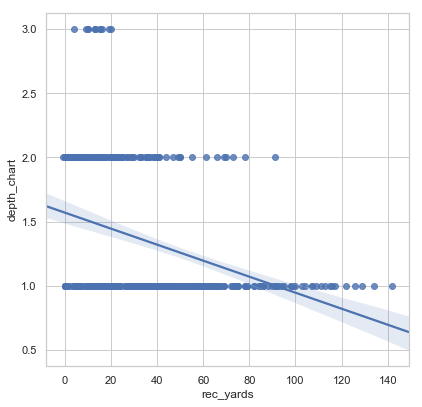

In [129]:
air_yard_plot = ay_df[(ay_df['tar'] > 1) & (ay_df['position'] == 'TE')].dropna()
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.regplot(x="rec_yards", y="depth_chart",
                data=air_yard_plot, ax=ax)

In [130]:
dvoa_fname = 'C:/Users/adamm/Desktop/dvoa.csv'
dvoa_df = pd.read_csv(dvoa_fname, header = 0)
dvoa_df

,Team,DVOA_WR1,Pa/G_WR1,Yd/G_WR1,DVOA_WR2,DVOA_WR2.1,Pa/G_WR2,Yd/G_WR2,DVOA_WR3,DVOA_WR3.1,Pa/G_WR3,Yd/G_WR3,DVOA_TE,DVOA_TE.1,Pa/G_TE,Yd/G_TE,DVOA_RB,DVOA_RB.1,Pa/G_RB,Yd/G_RB
0,NE,-34.50%,7.3,57.5,1,-49.90%,6.8,42.3,3,-40.10%,5.9,40.0,7,-10.60%,5.9,45.4,21,3.50%,6.7,36.7
1,SF,-9.00%,7.4,54.9,13,-2.80%,6.6,54.1,7,-15.80%,5.5,37.4,2,-33.40%,6.5,33.4,1,-63.80%,6.0,25.1
2,PIT,4.20%,7.3,62.3,5,-15.80%,6.9,47.3,26,20.40%,5.3,45.3,3,-25.30%,5.7,40.7,3,-36.70%,7.2,34.0
3,BAL,-16.10%,7.7,56.1,19,3.10%,6.6,67.6,2,-31.60%,6.8,45.8,10,-5.60%,6.1,36.5,8,-10.80%,5.3,28.6
4,BUF,-32.80%,8.0,56.2,4,-20.70%,6.7,46.6,12,-8.10%,5.3,42.1,14,-0.30%,5.7,38.7,14,-5.80%,7.4,42.5
5,KC,-32.30%,7.7,55.7,7,-10.40%,5.1,33.7,20,5.10%,6.5,43.8,4,-19.50%,9.0,58.5,18,-2.00%,7.6,58.0
6,MIN,5.40%,8.7,77.2,6,-13.90%,6.9,48.1,24,17.00%,6.2,52.8,1,-46.40%,7.4,50.7,11,-9.30%,6.3,38.1
7,CHI,-17.30%,7.7,62.8,17,2.10%,7.1,54.4,3,-29.40%,4.9,23.1,16,2.90%,7.6,58.5,12,-9.10%,6.8,38.5
8,GB,1.40%,7.5,71.0,3,-29.70%,6.3,47.8,9,-12.80%,4.8,37.3,26,9.80%,6.2,54.7,4,-17.00%,7.0,41.6
9,LAR,-18.00%,7.0,55.7,9,-5.90%,6.3,47.1,16,-2.60%,6.9,55.6,21,6.60%,7.5,54.6,22,9.30%,6.2,33.9
